In [ ]:
!pip install tensorflow==2.8.3
import tensorflow as tf
import numpy as np
import os
import random
import tensorboard
import datetime

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.8.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Random seed for reproducibility
seed = 54721

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
%cd /content/drive/MyDrive/ANN&DL
dataset_dir = 'training_data_final'
# image_size = 96
image_size = 256
batch_size = 64

In [ ]:
class_names = ['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']
class_samples = [0] * len(class_names)

In [ ]:
for i, class_name in enumerate(class_names):
    class_dir = '{}/{}/'.format(dataset_dir, class_name)
    class_samples[i] = len(os.listdir(class_dir))

In [ ]:
total_samples = sum(class_samples)
class_weight = list(total_samples / (len(class_names) * np.array(class_samples)))
class_weight = {i: class_weight[i] for i in range(len(class_weight))}

In [ ]:
print('Class weights: {}'.format(class_weight))

Class weights: {0: 2.3803763440860215, 1: 0.8322368421052632, 2: 0.8597087378640776, 3: 0.8664383561643836, 4: 0.833804143126177, 5: 1.9943693693693694, 6: 0.824487895716946, 7: 0.8715551181102362}


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.15,
    subset="training",
    shuffle=True,
    seed=seed,
    image_size=(image_size, image_size),
    batch_size=batch_size)

Found 3542 files belonging to 8 classes.
Using 3011 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.15,
    subset="validation",
    shuffle=True,
    seed=seed,
    image_size=(image_size, image_size),
    batch_size=batch_size)

Found 3542 files belonging to 8 classes.
Using 531 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 4)
validation_dataset = val_ds.skip(val_batches // 4)

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [ ]:
# Add caching to dataset
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Use one-hot encoding for labels
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

In [ ]:
crop_dim = 16
input_shape = (image_size, image_size, 3)
input_shape_cropping = (image_size-crop_dim*2, image_size-crop_dim*2, 3)

In [ ]:
import convnext

base_model = convnext.ConvNeXtBase(
    input_shape=input_shape_cropping,
    include_top=False,
    weights='imagenet',
    pooling='avg')
base_model.trainable = False

In [ ]:
model = tfk.Sequential([
    tfk.layers.Input(shape=input_shape),
    # Augmentation
    tfk.layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape),
    # tfk.layers.RandomRotation(0.5),
    tfk.layers.RandomZoom(0.5),
    tfk.layers.RandomTranslation(width_factor=0.1, height_factor=0.1),
    tfk.layers.Cropping2D(cropping=((crop_dim, crop_dim), (crop_dim, crop_dim)), input_shape=input_shape),

    # tfk.layers.Resizing(height=image_size, width=image_size, interpolation='bilinear', crop_to_aspect_ratio=False),
    
    # Preprocess for base model
    tfk.layers.Lambda(convnext.preprocess_input),
    # Transfer learning
    base_model,
    # Classification
    tfk.layers.Dense(384, activation='relu', kernel_initializer='he_uniform'),
    tfk.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
    # Dropout
    tfk.layers.Dropout(0.3),
    # Output
    tfk.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer=tfk.optimizers.Adagrad(learning_rate=0.01, initial_accumulator_value=0.1),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_translation_2 (Rando  (None, 256, 256, 3)      0         
 mTranslation)                                                   
                                                                 
 cropping2d_2 (Cropping2D)   (None, 224, 224, 3)       0         
                                                                 
 lambda_2 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 1024)              87566464  
                                                      

In [ ]:
epochs = 200

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weight,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)]
    ).history

Epoch 1/200
48/48 [==============================] - 41s 698ms/step - loss: 1.7292 - accuracy: 0.3713 - val_loss: 1.1860 - val_accuracy: 0.5782
Epoch 2/200
48/48 [==============================] - 32s 655ms/step - loss: 1.3185 - accuracy: 0.5247 - val_loss: 1.0663 - val_accuracy: 0.6278
Epoch 3/200
48/48 [==============================] - 32s 656ms/step - loss: 1.1775 - accuracy: 0.5795 - val_loss: 0.8437 - val_accuracy: 0.7047
Epoch 4/200
48/48 [==============================] - 32s 657ms/step - loss: 1.0673 - accuracy: 0.6270 - val_loss: 0.8197 - val_accuracy: 0.7146
Epoch 5/200
48/48 [==============================] - 32s 658ms/step - loss: 0.9541 - accuracy: 0.6682 - val_loss: 0.7497 - val_accuracy: 0.7196
Epoch 6/200
48/48 [==============================] - 32s 656ms/step - loss: 0.9285 - accuracy: 0.6762 - val_loss: 0.7666 - val_accuracy: 0.7320
Epoch 7/200
48/48 [==============================] - 32s 657ms/step - loss: 0.8672 - accuracy: 0.6911 - val_loss: 0.6971 - val_accuracy:

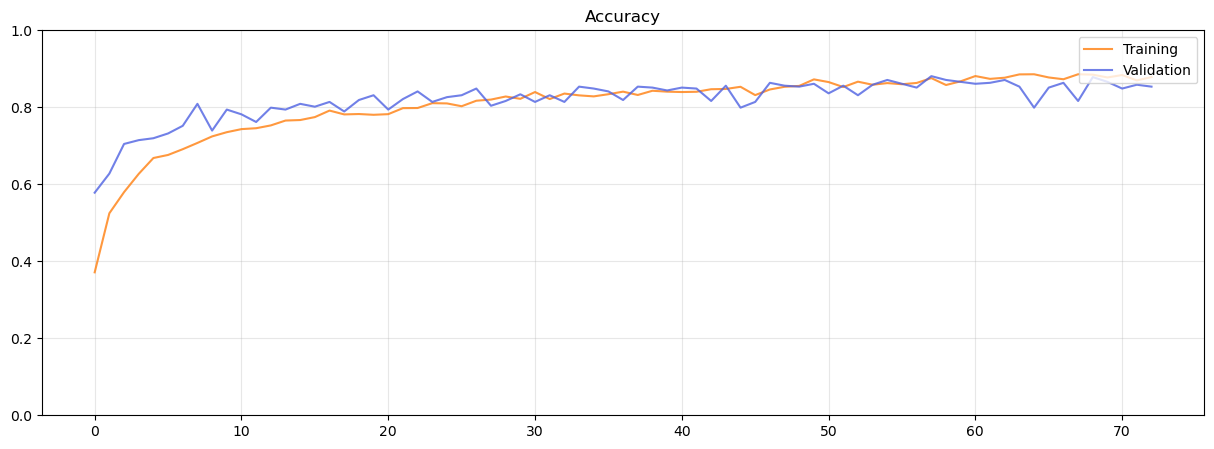

In [ ]:
import matplotlib.pyplot as plt

# plot the trend of the MSE of the training set (always decreasing of course) and of the validation set
plt.figure(figsize=(15, 5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Accuracy')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)
print("Loss", loss)

2/2 [==============================] - 1s 572ms/step - loss: 0.3747 - accuracy: 0.8750
Accuracy 0.875
Loss 0.37470096349716187


In [ ]:
# model.save("notebook24_5_1")

INFO:tensorflow:Assets written to: models/20221122-225409-0.875-nofinetuning\assets


INFO:tensorflow:Assets written to: models/20221122-225409-0.875-nofinetuning\assets


In [ ]:
# Fine Tuning
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable=False
for layer in base_model.layers[-10:]:
    layer.trainable=True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=tfk.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

# Train end-to-end. Be careful to stop before you overfit!
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weight,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
).history

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_translation_2 (Rando  (None, 256, 256, 3)      0         
 mTranslation)                                                   
                                                                 
 cropping2d_2 (Cropping2D)   (None, 224, 224, 3)       0         
                                                                 
 lambda_2 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 1024)              87566464  
                                                      

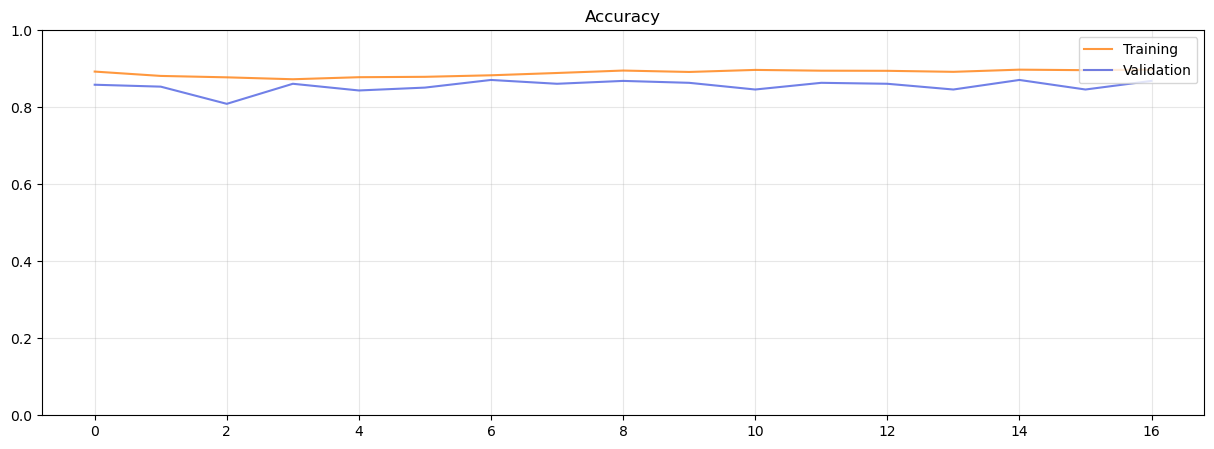

In [ ]:
import matplotlib.pyplot as plt

# plot the trend of the MSE of the training set (always decreasing of course) and of the validation set
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Accuracy')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)
print("Loss", loss)

2/2 [==============================] - 1s 578ms/step - loss: 0.5611 - accuracy: 0.8438
Accuracy 0.84375
Loss 0.5611171126365662


In [ ]:
model.save("ConvNext")

INFO:tensorflow:Assets written to: models/20221122-225824-0.875\assets


INFO:tensorflow:Assets written to: models/20221122-225824-0.875\assets


In [ ]:
base_model.summary()